# Environment Setup and Imports

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-grmdu99u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-grmdu99u
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=b83d0a834d91383e821a60cfb2fd8d26e13b6029b74fc0df5ec3e7a0f9603314
  Stored in directory: /tmp/pip-ephem-wheel-cache-cxw5o2da/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-01-08 06:34:06--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.34, 3

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=71357479690ab983b92ba423c3aaa557a6777829e43e9b4914e301903c6e8f50
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from google.colab.patches import cv2_imshow
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

## 2. Loading SAM

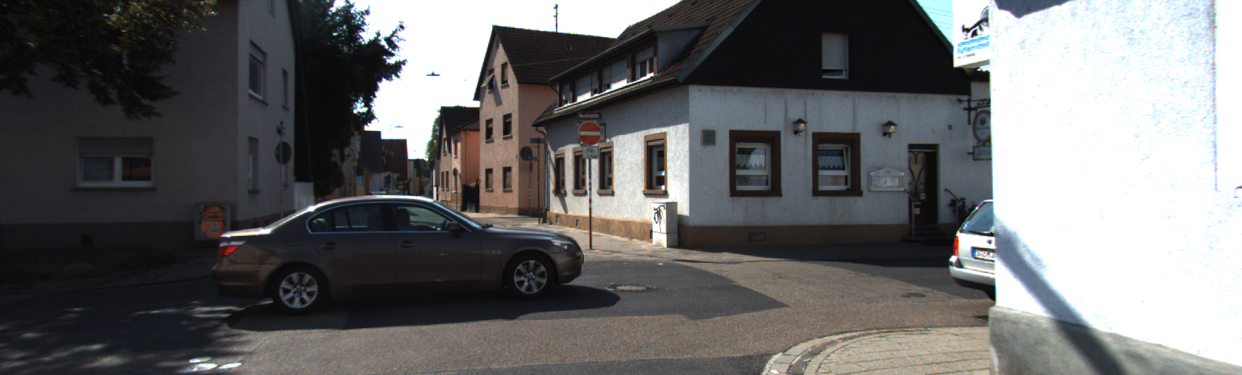

Original Image size - Width: 1242, Height: 375, Channels: 3


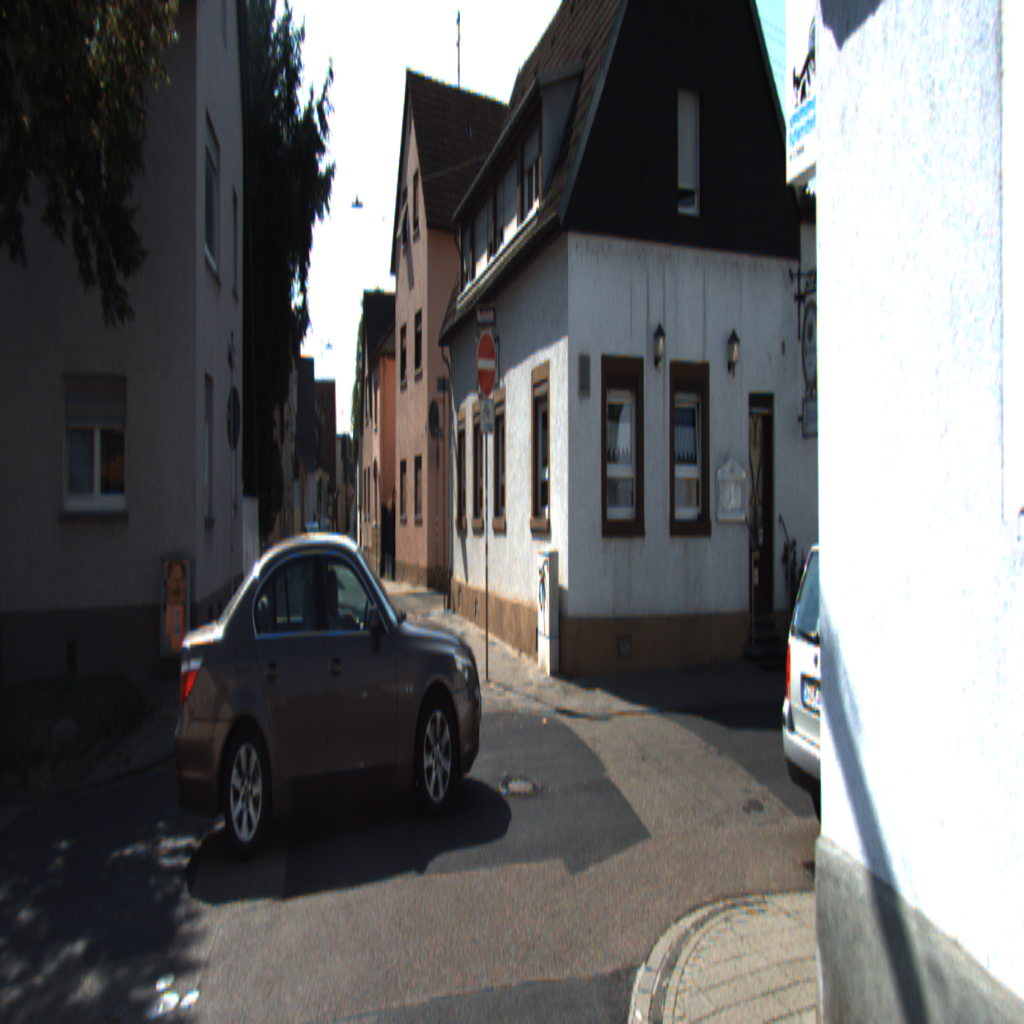

Resized Image Size - Width: 1024, Height: 1024


In [ ]:
# loading sample image # loading sample KITTI image
image = cv2.imread("000086_10.png")

if image is not None:
    # display the original image
    cv2_imshow(image)
    original_height, original_width, channels = image.shape
    print("Original Image size - Width: {}, Height: {}, Channels: {}".format(original_width, original_height, channels))

    # resize the image to 1024X1024 to prepare for input
    resized_image = cv2.resize(image, (1024, 1024))
    cv2_imshow(resized_image)
    resized_height, resized_width, _ = resized_image.shape
    print("Resized Image Size - Width: {}, Height: {}".format(resized_width, resized_height))

    image = resized_image

else:
    print("Error loading the image.")

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda') # use GPU
else:
  device = torch.device('cpu') # use CPU if GPU is unavailable

sam = sam_model_registry["vit_h"](checkpoint="/content/sam_vit_h_4b8939.pth")
sam.to(device)

# sam predictor
predictor = SamPredictor(sam)

# sam mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
# function to show annotations
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

## 3. Mask Generation

In [ ]:
# generate masks
masks = mask_generator.generate(image)

In [ ]:
# sorting masks by area
masks = sorted(masks, key=(lambda x: x['area']), reverse=True)

In [ ]:
# mask shape
print(masks[0]['segmentation'].shape)

(375, 1242)


In [ ]:
print('No. of masks generated', len(masks))

No. of masks generated 82


In [ ]:
# display generated masks
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## 4. Extract image patch embeddings from the image encoder

In [ ]:
mask_generator.predictor.set_image(image)
patch_emb = mask_generator.predictor.features
print(patch_emb.shape)

torch.Size([1, 256, 64, 64])


In [ ]:
patch_emb = patch_emb.to("cpu").numpy()
patch_emb = patch_emb[0].transpose((1,2,0))
print(patch_emb.shape)

(64, 64, 256)


- iterate through the masks
- fetch the patches for each mask, and the embeddings for each of those patches
- fetch the mask embedding for each mask, i.e., average the patch embeddings for all patches belonging to the mask

In [ ]:
def get_mask_embedding_using_patch_embeddings(mask, enc_emb, return_all = False):
    # Converting mask of shape 1024x1024 to shape: 64x64x16x16
    # This assumes that patch size is 16x16 becuase what we mainly need is: 64x64 at the start
    # We are free to change the patch-size accordingly
    split_mask = np.array(np.split(mask, 23, axis = -1))
    split_mask = np.array(np.split(split_mask, 78, axis = -2))
    split_mask = split_mask*1 # split_mask is a mask of shape: 64x64x16x16
    # split_mask is binary (have value of 0 or 1 not between)

    # Converting split_mask of shape: 64x64x16x16 to 64x64
    # by adding all numbers in every 16x16 grid
    split_mask = np.sum(split_mask, axis = -1)
    split_mask = np.sum(split_mask, axis = -1)

    # Get all patch embeddings from this split_mask of 64x64
    # In this split_mask, at all locations where the cell-value is greater than 1,
    # It means that we need to pick the patch-embeddding at this given index (X,Y) value
    patch_locations = np.where(split_mask > 1)
    n_patch_embeddings = enc_emb[patch_locations]
    mask_embedding = n_patch_embeddings.mean(axis = 0, keepdims = False)

    if return_all:
        return mask_embedding, patch_locations, n_patch_embeddings
    return mask_embedding

In [ ]:
mask_embeddings = []
for i in range(len(masks)):
    nth_mask = masks[i]['segmentation']
    nth_mask_emb = get_mask_embedding_using_patch_embeddings(nth_mask, patch_emb)
    mask_embeddings.append(nth_mask_emb)

mask_embeddings_arr = np.array(mask_embeddings)
print("Mask Embedding shape: ", mask_embeddings_arr.shape)

Each row in mask_embeddings_arr represents a mask embedding, and each column represents a feature/dimension of that embedding.

In [ ]:
# accessing the embedding for the first mask
print(mask_embeddings_arr[0, :].shape)

(256,)


- 74 masks
- each mask now has a mask-embedding of shape 1X256

## 5. Clustering of mask embeddings

### Clustering using OPTICS

[-1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1
 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1  0  0 -1  0 -1  0 -1  0 -1 -1  0
  0 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


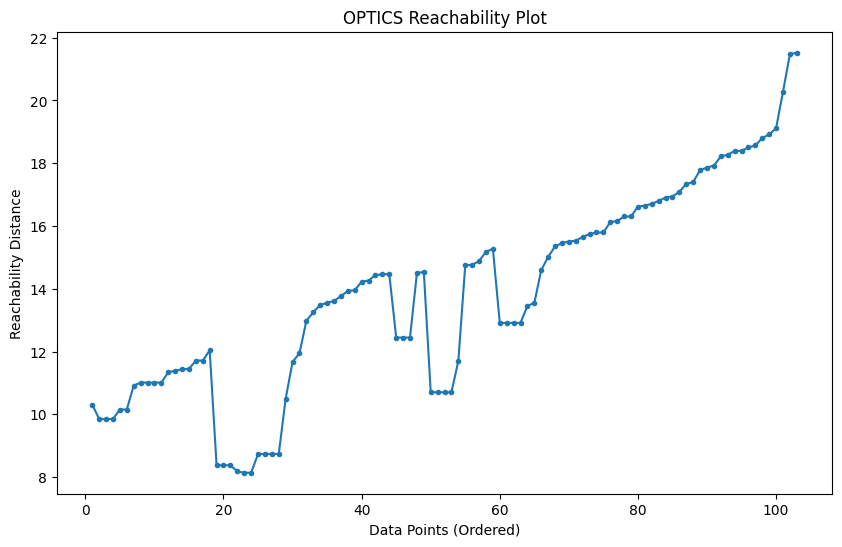

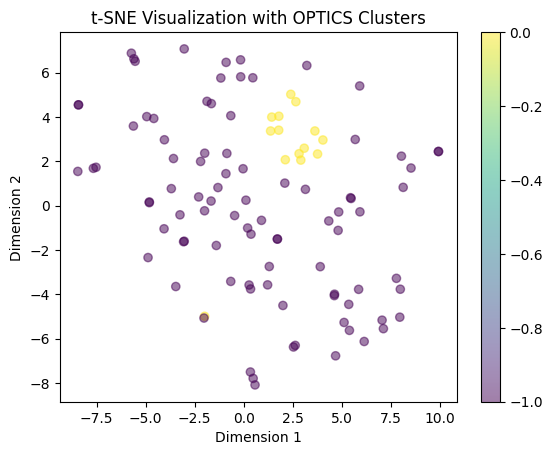

In [ ]:
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

scaler = StandardScaler()
normalized_data = scaler.fit_transform(mask_embeddings_arr)

optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
optics.fit(normalized_data)

optics_labels = optics.labels_
print(optics_labels)

reachability = optics.reachability_[optics.ordering_]
plt.figure(figsize=(10, 6))
plt.plot(range(len(reachability)), reachability, marker='.')
plt.title('OPTICS Reachability Plot')
plt.xlabel('Data Points (Ordered)')
plt.ylabel('Reachability Distance')
plt.show()

tsne = TSNE(n_components=2, random_state=42)
embedded_data = tsne.fit_transform(normalized_data)

plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=optics_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization with OPTICS Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

Clustering labels:

In [ ]:
print("Clustering Labels: ", np.unique(optics_labels))

Clustering Labels:  [-1  0]


## Visualization of foreground-background separation:

Label: -1

Number of items in cluster -1:  (90,)


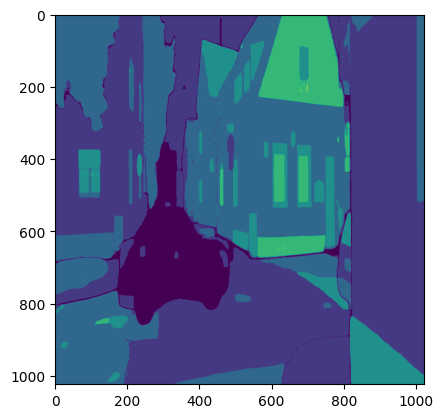

In [ ]:
label_minus1 = np.where(optics_labels == -1)
print("Number of items in cluster -1: ", label_minus1[0].shape)

lblminus1_semantic_seg_mask = masks[-1]['segmentation']*1
for seg_no in label_minus1[0]:
    lblminus1_semantic_seg_mask += masks[seg_no]['segmentation']*1

plt.imshow(lblminus1_semantic_seg_mask)

Label: 0

Number of items in cluster 0:  (14,)


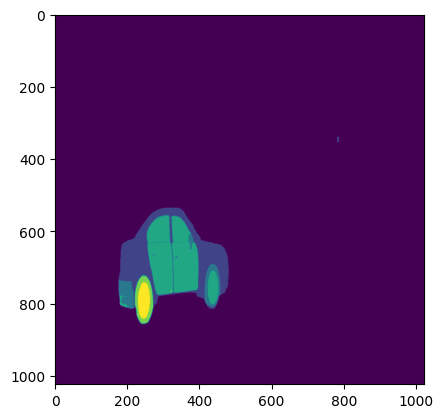

In [ ]:
label_0 = np.where(optics_labels == 0)
print("Number of items in cluster 0: ", label_0[0].shape)

lbl0_semantic_seg_mask = masks[-1]['segmentation']*1
for seg_no in label_0[0]:
    lbl0_semantic_seg_mask += masks[seg_no]['segmentation']*1

plt.imshow(lbl0_semantic_seg_mask)